# ML Bio Projet

Vous travaillez pour une entreprise qui propose une application pour les dermatologue qui permet de classer automatiquement les maladies de la peau. 

Vous devez donc développer, entraîner et évaluer un ou plusieurs modèle de machine learning qui indique quelle est la maladie présente sur une photographique d'un morceau de peaux. 

Vous pourrez utiliser du deep learning.

Un jeu de donnée de maladie de peau, le HAM 10 000 est accessible publiquement. 

Vous pouvez en utiliser un sous ensemble.

Quelques pistes : 

Vous pouvez si vous le souhaitez entraîner votre propre réseau. 

Vous pouvez utiliser du transfert learning.

Vous pouvez utiliser des techniques d'interpretabilité de modèles comme LIME (sera valorisé par votre cher enseignant)

Les données peuvent etre récupérées [ici](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

from os import listdir
from os.path import isfile, join

from PIL import Image

import random

plt.rcParams["savefig.bbox"] = 'tight'

In [3]:
META = "drive/MyDrive/Data/HAM10000/HAM10000_metadata.csv"
IMAGES_TRAIN = "drive/MyDrive/Data/HAM10000/HAM10000_images_train/"
IMAGES_TEST = "drive/MyDrive/Data/HAM10000/HAM10000_images_test/"
LESION_TYPE = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
TYPE_CARDINAL = {
    'Melanocytic nevi': 0,
    'dermatofibroma': 1,
    'Benign keratosis-like lesions': 2,
    'Basal cell carcinoma': 3,
    'Actinic keratoses': 4,
    'Vascular lesions': 5,
    'Dermatofibroma': 6
}

# LOAD DATA

In [4]:
def get_existing_images(path):
    return [f for f in listdir(path) if isfile(join(path, f))]

def get_metadata(dataset, images):
    dataset["image_id"] = dataset['image_id'].map(lambda x: x + ".jpg")
    return dataset[dataset['image_id'].isin(images)]

def load_image_info(path_meta, path_images, type_dict, cardinal_dict):
    meta = pd.read_csv(path_meta)[["image_id", "dx"]]
    images = get_existing_images(path_images)
    meta = get_metadata(meta, images)

    meta['image_id'] = meta['image_id'].map(lambda x: path_images + x)
    meta['type'] = meta['dx'].map(lambda x: type_dict[x])
    meta['label'] = meta['type'].map(lambda x: cardinal_dict[x])

    return meta.drop(columns=['dx'])

In [5]:
metadata_train = load_image_info(META, IMAGES_TRAIN, LESION_TYPE, TYPE_CARDINAL)
metadata_test = load_image_info(META, IMAGES_TEST, LESION_TYPE, TYPE_CARDINAL)
metadata_train.head(10)

,image_id,type,label
2,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
3,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
22,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
24,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
43,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
53,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
54,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
62,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
67,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2
75,drive/MyDrive/Data/HAM10000/HAM10000_images_tr...,Benign keratosis-like lesions,2


# Display data

In [6]:
def show_images(metadata):
    plt.figure(figsize=(10,10))

    size = len(metadata)

    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        val = random.randrange(size)

        image = mpimg.imread(metadata.iloc[val, 0])
        plt.imshow(image)
        plt.xlabel(metadata.iloc[val, 1])
    plt.show()

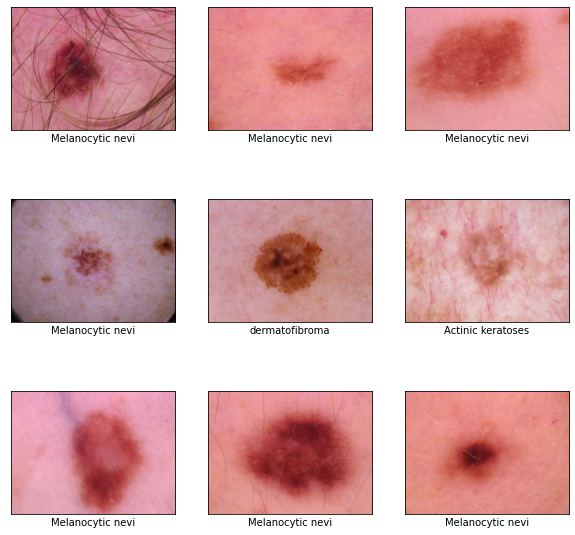

In [7]:
show_images(metadata_train)

In [8]:
nb_classes = len(metadata_train['type'].unique())
nb_classes

7

In [9]:
metadata_train['type'].value_counts()

Melanocytic nevi                 865
Benign keratosis-like lesions    128
dermatofibroma                    98
Basal cell carcinoma              63
Actinic keratoses                 31
Vascular lesions                  13
Dermatofibroma                    12
Name: type, dtype: int64

# Create Dataset

In [10]:
# define the transformation of the train images.
train_transform = transforms.Compose(
    [
        transforms.ToTensor(), # Scale image to [0, 1]
    ])

# define the transformation of the val images.
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ])

In [11]:
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        X = Image.open(self.df.iloc[index, 0])
        
        if self.transform:
            X = self.transform(X)

        y = torch.tensor(self.df.iloc[index, 2], dtype=torch.long)

        return X, y

In [12]:
dataset_train = HAM10000(metadata_train, train_transform)
dataset_test = HAM10000(metadata_test, test_transform)

In [13]:
batch_size = 64
train_data = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

for X, y in train_data:
    print(f"Shape of X: {X.size()}")
    print(f"Shape of y: {y.size()}")
    break

Shape of X: torch.Size([64, 3, 450, 600])
Shape of y: torch.Size([64])


# Create and train model

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [15]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding=0):
    super().__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, padding=padding)
    # We don't need the bias when used with BN because the BN also contains a bias
    self.bn = nn.BatchNorm2d(out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

  def forward(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.pool(x)
    return F.relu(x, inplace=True)

In [16]:
class MLBioNN(nn.Module):
    def __init__(self, output_size):
        super().__init__()

        self.conv1 = ConvBlock(3, 10, 3, padding=1)     # 3 * 450 * 600 * 10
        self.conv2 = ConvBlock(10, 20, 3, padding=1)    # 10 * 225 * 300 * 20
        self.conv3 = ConvBlock(20, 40, 3, padding=1)    # 20 * 112 * 150 * 40
        self.conv4 = ConvBlock(40, 80, 3, padding=1)    # 40 * 56 * 75 * 80
        self.flatten = nn.Flatten()                     # 80 * 28 * 37
        self.dense = nn.Linear(80 * 28 * 37, output_size)   

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        
        return self.dense(x)

model_mlbio = MLBioNN(nb_classes)
model_mlbio

MLBioNN(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlbio.parameters())

In [18]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    model = model.to(device)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        loss = loss_function(prediction, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [19]:
def test(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model = model.to(device)
    model.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            test_loss += loss_function(prediction, y).item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data, model_mlbio, loss_function, optimizer)
    test(train_data, model_mlbio, loss_function)
    test(test_data, model_mlbio, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 0.966575 [    0/ 1210]
loss: 1.864844 [  320/ 1210]
loss: 2.159200 [  640/ 1210]
loss: 3.326374 [  960/ 1210]
Test Error: 
 Accuracy: 59.3%, Avg loss: 0.998596 

Test Error: 
 Accuracy: 44.4%, Avg loss: 1.271719 

Epoch 2
-------------------------------
loss: 2.830395 [    0/ 1210]
loss: 2.593262 [  320/ 1210]
loss: 0.922631 [  640/ 1210]
loss: 1.726003 [  960/ 1210]
Test Error: 
 Accuracy: 66.7%, Avg loss: 1.411787 

Test Error: 
 Accuracy: 51.3%, Avg loss: 2.327186 

Epoch 3
-------------------------------
loss: 1.389794 [    0/ 1210]
loss: 0.636311 [  320/ 1210]
loss: 0.819020 [  640/ 1210]
loss: 1.356877 [  960/ 1210]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.927988 

Test Error: 
 Accuracy: 66.8%, Avg loss: 1.674732 

Epoch 4
-------------------------------
loss: 0.475447 [    0/ 1210]
loss: 0.641747 [  320/ 1210]
loss: 1.488155 [  640/ 1210]
loss: 0.689509 [  960/ 1210]
Test Error: 
 Accuracy: 73.0%, Avg loss: 0.809091 

Test Error: 

# Save model

In [22]:
torch.save(model_mlbio.state_dict(), "model_mlbio.pth")
print("Saved PyTorch Model State to model_mlbio.pth")

Saved PyTorch Model State to model_mlbio.pth


In [28]:
img, label = dataset_train[0]
with torch.no_grad():
    img = img.to(device)
    pred = model_mlbio(img.unsqueeze(0))
    pred = pred.argmax(1).item()

    print(pred, label)

3 tensor(2)


In [29]:
model_mlbio_cpu = model_mlbio.to("cpu")

In [32]:
img, label = dataset_train[0]
with torch.no_grad():
    pred = model_mlbio(img.unsqueeze(0))
    pred = pred.argmax(1).item()

    print(pred, label)

3 tensor(2)


In [33]:
torch.save(model_mlbio_cpu.state_dict(), "model_mlbio_cpu.pth")
print("Saved PyTorch Model State to model_mlbio_cpu.pth")

Saved PyTorch Model State to model_mlbio_cpu.pth
